## 🎯 Objetivo
##### En este escenario, se pretende construir un modelo predictivo global capaz de estimar el número de calorías quemadas durante una sesión de entrenamiento, utilizando como entrada las características físicas del usuario y sus hábitos de ejercicio.

##### A diferencia del Escenario A, donde se entrenaron modelos diferenciados por cluster de usuario, aquí se utilizará el conjunto de datos completo para entrenar un único modelo general. El objetivo es comparar su rendimiento respecto al enfoque basado en clusters y evaluar qué estrategia ofrece mejores resultados de predicción.

### Paso 1. Cargar dataset con los clusters asignados

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Cargar el dataset
dataset = pd.read_csv("archivo_gym_members_exercise_tracking_version2.csv")
dataset = dataset.drop(columns=['id'])
dataset = dataset.drop(columns=['Gender'])
# Verificar columnas
print(dataset.columns,"\n")


Index(['Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
       'Session_Duration (hours)', 'Calories_Burned', 'Fat_Percentage',
       'Water_Intake (liters)', 'Workout_Frequency (days/week)',
       'Experience_Level', 'BMI', 'Workout_Cardio', 'Workout_HIIT',
       'Workout_Strength', 'Workout_Yoga'],
      dtype='object') 



### Selección de variables X (predictoras) e y (objetivo)

In [50]:
# Variable objetivo
y = dataset['Calories_Burned']

# Variables predictoras
X = dataset.drop(columns=['Calories_Burned'])

# Revisión rápida
print("Variables predictoras:", X.columns.tolist())
print("Variable objetivo:", y.name)

Variables predictoras: ['Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)', 'Fat_Percentage', 'Water_Intake (liters)', 'Workout_Frequency (days/week)', 'Experience_Level', 'BMI', 'Workout_Cardio', 'Workout_HIIT', 'Workout_Strength', 'Workout_Yoga']
Variable objetivo: Calories_Burned


### División en train/test y escalado
Vamos a dividir los datos en entrenamiento y prueba (80% / 20%) y aplicar escalado estándar solo sobre X.

In [51]:
# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Escalado de variables predictoras
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Entrenamiento de modelos
Se entrenarán tres algoritmos de regresión sobre el conjunto de entrenamiento ya escalado:
- Regresión Lineal
- Random Forest
- Gradient Boosting

In [52]:
# Inicializar modelos
modelo_lr = LinearRegression()
modelo_rf = RandomForestRegressor(random_state=42)
modelo_gb = GradientBoostingRegressor(random_state=42)

# Entrenamiento
modelo_lr.fit(X_train_scaled, y_train)
modelo_rf.fit(X_train_scaled, y_train)
modelo_gb.fit(X_train_scaled, y_train)

# Guardar scaler y el modelo
joblib.dump(scaler, 'API/models/scaler_global.pkl')
joblib.dump(modelo_gb, 'API/models/gb_global.pkl')

['API/models/gb_global.pkl']

### Evaluación de los modelos
Se evaluará el rendimiento de cada modelo utilizando las siguientes métricas:
- R² (coeficiente de determinación)
- MAE (error absoluto medio)
- RMSE (raíz del error cuadrático medio)

In [53]:
print("\nR² Score: mide qué tanto del valor de y se puede explicar con X (ideal cercano a 1).\nRMSE: mide el error promedio entre las predicciones y los valores reales (más bajo = mejor).\n")
# Función para evaluar modelos
def evaluar_modelo(nombre, modelo, X_test, y_test):
    predicciones = modelo.predict(X_test)
    r2 = r2_score(y_test, predicciones)
    mae = mean_absolute_error(y_test, predicciones)
    rmse = np.sqrt(mean_squared_error(y_test, predicciones))
    print(f" {nombre}")
    print(f"R²:   {r2:.4f}")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print("-" * 30)
    return predicciones

# Evaluar todos los modelos
pred_lr = evaluar_modelo("Regresión Lineal", modelo_lr, X_test_scaled, y_test)
pred_rf = evaluar_modelo("Random Forest", modelo_rf, X_test_scaled, y_test)
pred_gb = evaluar_modelo("Gradient Boosting", modelo_gb, X_test_scaled, y_test)



R² Score: mide qué tanto del valor de y se puede explicar con X (ideal cercano a 1).
RMSE: mide el error promedio entre las predicciones y los valores reales (más bajo = mejor).

 Regresión Lineal
R²:   0.9740
MAE:  35.99
RMSE: 46.61
------------------------------
 Random Forest
R²:   0.9689
MAE:  39.42
RMSE: 50.97
------------------------------
 Gradient Boosting
R²:   0.9903
MAE:  22.16
RMSE: 28.51
------------------------------


### Gráficos Real vs. Prediccion
Se representará gráficamente la relación entre los valores reales y predichos de calorías para cada modelo.  
La línea roja indica el ajuste perfecto. Cuanto más se alineen los puntos a esa línea, mejor será la precisión del modelo.

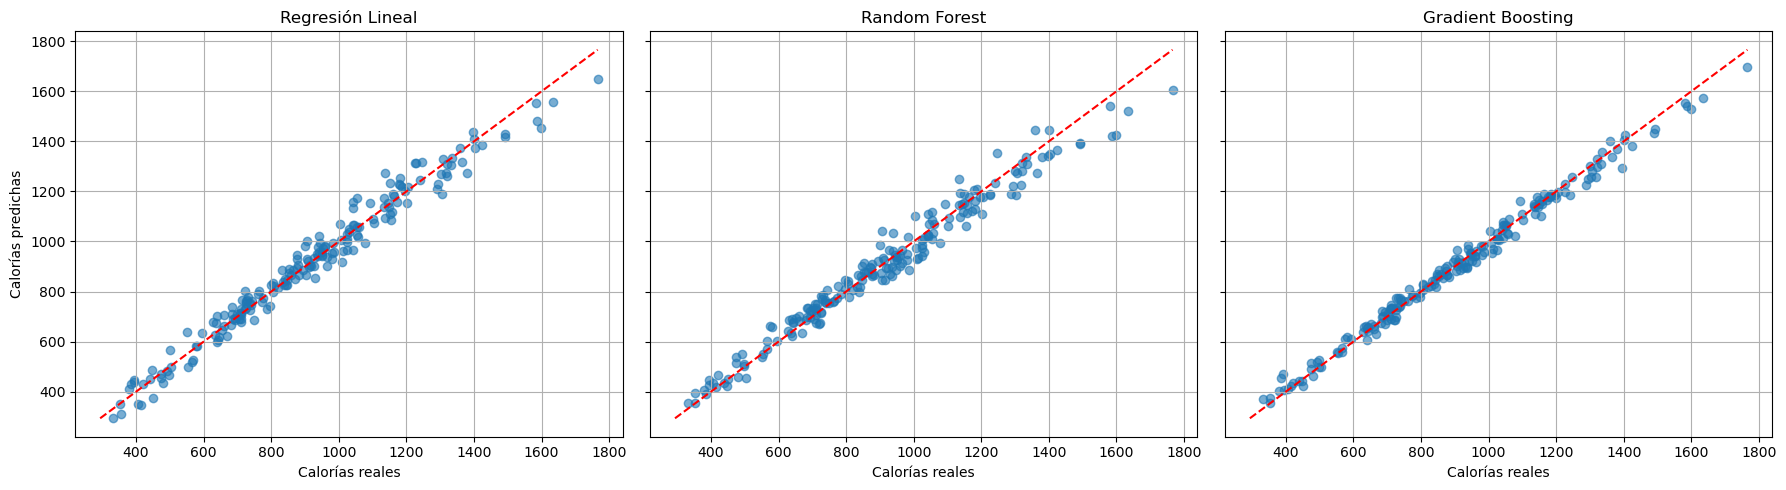

In [54]:
def graficar_en_fila(y_real, y_preds, nombres):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), sharex=True, sharey=True)
    
    # Obtener los límites globales para la línea de identidad
    y_min = min(y_real.min(), min(pred.min() for pred in y_preds))
    y_max = max(y_real.max(), max(pred.max() for pred in y_preds))
    
    for i, (y_pred, nombre) in enumerate(zip(y_preds, nombres)):
        ax = axes[i]
        ax.scatter(y_real, y_pred, alpha=0.6)
        ax.plot([y_min, y_max], [y_min, y_max], 'r--')
        ax.set_xlabel('Calorías reales')
        if i == 0:
            ax.set_ylabel('Calorías predichas')
        ax.set_title(nombre)
        ax.grid(True)
    
    # Ajustar layout para que no se solapen etiquetas
    plt.tight_layout()
    plt.show()

# Ejemplo de uso:
y_preds = [pred_lr, pred_rf, pred_gb]
nombres = ["Regresión Lineal", "Random Forest", "Gradient Boosting"]
graficar_en_fila(y_test, y_preds, nombres)


## 🎯 Objetivo:
##### Dado un nuevo registro (una nueva sesión), predecir las calorías quemadas.

In [56]:
# Datos de un nuevo usuario
nuevo_usuario = pd.DataFrame([{
    'Age': 37,
    'Gender': 0,
    'Weight (kg)': 95,
    'Height (m)': 1.86,
    'BMI': 2.7,
    'Fat_Percentage': 18,
    'Experience_Level': 2,
    'Workout_Frequency (days/week)': 3,
    'Workout_Cardio': 1,
    'Workout_HIIT': 0,
    'Workout_Strength': 0,
    'Workout_Yoga': 0,
    'Water_Intake (liters)': 2.5,
    'Max_BPM': 175,
    'Avg_BPM': 140,
    'Resting_BPM': 70,
    'Session_Duration (hours)': 1.0
}])

nuevo_usuario = nuevo_usuario[X.columns]
# Escalar las variables
nuevo_usuario_scaled = scaler.transform(nuevo_usuario)

# Predicción con el modelo de Gradient Boosting
pred = modelo_gb.predict(nuevo_usuario_scaled)[0]

# Resultado
print("➡️ Escenario B")
print(f"🔥 Calorías estimadas: {pred:.2f}")


➡️ Escenario B
🔥 Calorías estimadas: 769.19


In [57]:
nuevo_usuario2 = pd.DataFrame([{
    'Age': 52,
    'Gender': 0,
    'Weight (kg)': 92,
    'Height (m)': 1.65,
    'BMI': 33.8,
    'Fat_Percentage': 32,
    'Experience_Level': 1,
    'Workout_Frequency (days/week)': 1,
    'Workout_Cardio': 0,
    'Workout_HIIT': 0,
    'Workout_Strength': 0,
    'Workout_Yoga': 1,
    'Water_Intake (liters)': 0.8,
    'Max_BPM': 140,
    'Avg_BPM': 110,
    'Resting_BPM': 75,
    'Session_Duration (hours)': 0.5
}])

nuevo_usuario2 = nuevo_usuario2[X.columns]

# Escalar
nuevo_usuario2_scaled = scaler.transform(nuevo_usuario2)

# Predicción
pred2 = modelo_gb.predict(nuevo_usuario2_scaled)[0]

# Resultado
print("➡️ Escenario B")
print(f"🔥 Calorías estimadas: {pred2:.2f}")


➡️ Escenario B
🔥 Calorías estimadas: 304.46


In [58]:
usuario_comparativo = pd.DataFrame([{
    'Age': 35,
    'Gender': 1,
    'Weight (kg)': 85,
    'Height (m)': 1.80,
    'BMI': 26.2,
    'Fat_Percentage': 20,
    'Experience_Level': 2,
    'Workout_Frequency (days/week)': 3,
    'Workout_Cardio': 1,
    'Workout_HIIT': 1,
    'Workout_Strength': 1,
    'Workout_Yoga': 0,
    'Water_Intake (liters)': 1.8,
    'Max_BPM': 172,
    'Avg_BPM': 138,
    'Resting_BPM': 68,
    'Session_Duration (hours)': 1.0
}])

usuario_comparativo_b = usuario_comparativo[X.columns]
usuario_comparativo_scaled = scaler.transform(usuario_comparativo_b)
pred_b = modelo_gb.predict(usuario_comparativo_scaled)[0]
print("➡️ ESCENRIO B")
print(f"🔥 Calorías estimadas: {pred_b:.2f}")


➡️ ESCENRIO B
🔥 Calorías estimadas: 743.85


## 🟦 COMPARATIVA DEL MISMO USUARIO DEL DATASET CON ESCENARIO B

In [59]:
# Seleccionar un usuario (puede ser el primero del dataset)
usuario_real = dataset.iloc[1].copy()

# Guardar las calorías reales para comparar después
calorias_reales = usuario_real['Calories_Burned']

# Mostrar datos del usuario
print(usuario_real)
print(f"🔥 Calorías reales: {calorias_reales:.2f}")


Age                               46.00
Weight (kg)                       74.90
Height (m)                         1.53
Max_BPM                          179.00
Avg_BPM                          151.00
Resting_BPM                       66.00
Session_Duration (hours)           1.30
Calories_Burned                  883.00
Fat_Percentage                    33.90
Water_Intake (liters)              2.10
Workout_Frequency (days/week)      4.00
Experience_Level                   2.00
BMI                               32.00
Workout_Cardio                     0.00
Workout_HIIT                       1.00
Workout_Strength                   0.00
Workout_Yoga                       0.00
Name: 1, dtype: float64
🔥 Calorías reales: 883.00


In [60]:
# Reutilizar usuario_df de Escenario A
usuario_b = dataset[X.columns]  # reordenar columnas como en el modelo global

# Escalar y predecir
usuario_scaled_b = scaler.transform(usuario_b)
pred_b = modelo_gb.predict(usuario_scaled_b)[0]

print("➡️ Escenario B")
print(f"⭐ Calorías reales: {calorias_reales:.2f}")
print(f"🔥 Calorías estimadas (Escenario B): {pred_b:.2f}")
print(f"Diferencia de calorias::::", np.abs(calorias_reales - pred_b))



➡️ Escenario B
⭐ Calorías reales: 883.00
🔥 Calorías estimadas (Escenario B): 1321.67
Diferencia de calorias:::: 438.6668692101582
